In [1]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import random_split
import warnings

warnings.filterwarnings("ignore")

device=  "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

data_path = "C:/cv/hair/hair"
print(os.listdir(data_path))


cuda:0
['Curly Hair', 'Straight Hair', 'Wavy Hair']


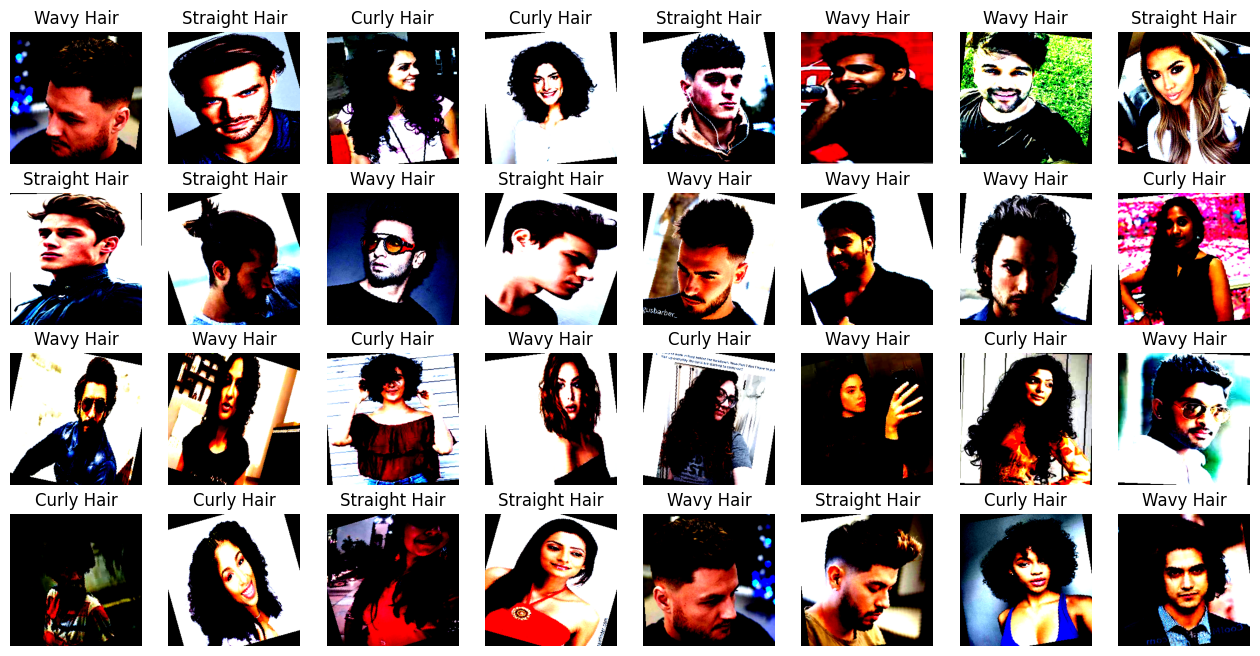

In [2]:
labels = ['Curly Hair', 'Straight Hair', 'Wavy Hair']


transformed_data = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])


dataset = datasets.ImageFolder(data_path,transformed_data)


train_split = int(len(dataset) * 0.8)
test_split = len(dataset) - train_split

train_data,test_data = random_split(dataset, lengths=[train_split,test_split])


BATCH_SIZE = 64
n_classes = 3
learning_rate = 0.001
epochs = 10



train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)


images,labels = next(iter(train_dataloader))







fig,axs = plt.subplots(4,8,figsize=(16,8))

for i,ax in enumerate(axs.flat):
    image = images[i].numpy().transpose((1,2,0))
    image = np.clip(image,0,1)
    ax.imshow(image)
    ax.set_title(dataset.classes[labels[i]])
    ax.axis("off")
plt.show()
    

In [3]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


for param in model.layer4.parameters():
    param.requires_grad = True




num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,3)
)

model.to(device)




optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(epochs):
    running_loss = 0
    for i,(images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader):.4f}")
        scheduler.step()

Epoch [1/10], Loss: 0.0890
Epoch [1/10], Loss: 0.1533
Epoch [1/10], Loss: 0.2019
Epoch [1/10], Loss: 0.2530
Epoch [1/10], Loss: 0.2959
Epoch [1/10], Loss: 0.3275
Epoch [1/10], Loss: 0.3833
Epoch [1/10], Loss: 0.4251
Epoch [1/10], Loss: 0.4657
Epoch [1/10], Loss: 0.5156
Epoch [1/10], Loss: 0.5642
Epoch [1/10], Loss: 0.6048
Epoch [1/10], Loss: 0.6428
Epoch [2/10], Loss: 0.0372
Epoch [2/10], Loss: 0.0855
Epoch [2/10], Loss: 0.1166
Epoch [2/10], Loss: 0.1594
Epoch [2/10], Loss: 0.1989
Epoch [2/10], Loss: 0.2326
Epoch [2/10], Loss: 0.2822
Epoch [2/10], Loss: 0.3326
Epoch [2/10], Loss: 0.3749
Epoch [2/10], Loss: 0.4149
Epoch [2/10], Loss: 0.4535
Epoch [2/10], Loss: 0.4927
Epoch [2/10], Loss: 0.5372
Epoch [3/10], Loss: 0.0369
Epoch [3/10], Loss: 0.0740
Epoch [3/10], Loss: 0.1156
Epoch [3/10], Loss: 0.1586
Epoch [3/10], Loss: 0.1948
Epoch [3/10], Loss: 0.2353
Epoch [3/10], Loss: 0.2728
Epoch [3/10], Loss: 0.3076
Epoch [3/10], Loss: 0.3479
Epoch [3/10], Loss: 0.3810
Epoch [3/10], Loss: 0.4145
E

In [4]:


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images,labels in test_dataloader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,preds = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))



Test Accuracy of the model on the 10000 test images: 70.3125 %
Test Accuracy of the model on the 10000 test images: 71.875 %
Test Accuracy of the model on the 10000 test images: 72.39583333333333 %
Test Accuracy of the model on the 10000 test images: 72.36180904522612 %


In [5]:
## resnet18 is awesome!